In [ ]:
from goods_s.objects import *
from os import remove
from shutil import rmtree
import time 
from sedpy.observate import load_filters
from astropy.convolution import convolve


'''
Run the double power law SFH BAGPIPES on a pixel-by-pixel basis for a single object.
'''
objid = 117602 
run_name = f'1obj_{objid}'
# z = BURSTY_OBJIDS_Z[BURSTY_OBJIDS == objid][0] # Photometric redshift from Charlotte's catalog
z = 7.430 # Photometric (Kevin's unconvolved CIRC1, within range of Hodge et al. 2025 zphot)
print(f'Redshift used: z = {z}')
o = obj(objid)
Ncut = 50 # Length of pixel cutout
clear_posterior = False # Whether or not to clear the BAGPIPES posterior, plots, and catalog files for this run

# List of filter .par paths to feed into BAGPIPES
# filters = MOSAIC_NAMES 
filters = ['F090W', 'F115W', 'F150W', 'F182M', 'F200W', 'F210M', 'F277W', 'F335M', 'F356W', 'F410M', 'F444W']
filt_objs = load_filters([f'jwst_{f.lower()}' for f in filters]) # sedpy.observate filter objects
filt_list = [f.filename for f in filt_objs]
Nfilt = len(filters)
# filt_list = []
# for i in range(Nfilt):
    # filt_list.append(FILTER_PAR_PATH + MOSAIC_NAMES[i] + '.par')

# Load PSF for F770W, convolve to F770W resolution
hdul = fits.open('/home/marcia/psf_f770w.apodized.fits')
f770w_psf = hdul[0].data[:167, :167]

# Gather data cutout, error cutout, background, and Sr per pixel for each filter
data = np.zeros((Nfilt, Ncut, Ncut))
sigma = np.zeros((Nfilt, Ncut, Ncut))
bkg = np.zeros(Nfilt)
sr_pix = np.zeros(Nfilt)

for i, filt in enumerate(filters):
    # data[i, :, :], sigma[i, :, :], bkg[i], sr_pix[i] = o.get_mosaic_cut(filt, n=Ncut)
    data_i, sigma_i, bkg[i], sr_pix[i] = o.get_mosaic_cut(filt, n=Ncut)
    if filt != 'F770W':
        # data[i, :, :] = convolve(data_i, f770w_psf)
        # sigma[i, :, :] = convolve(data_i, f770w_psf)
        data[i, :, :] = data_i
        sigma[i, :, :] = sigma_i
    else:
        data[i, :, :] = data_i
        sigma[i, :, :] = sigma_i

snr = data / sigma # For pixel masking

# Create a mask that ensures good (>3) SNR and that pixels belong to the object in each filter
mask = np.zeros((Ncut, Ncut))
thres = 1.5 # Starting threshold for masking routine
x0 = int(Ncut/2) # Center of cutout
for i in range(Nfilt):
    segmap, cent, flag = make_segmap(data[i, :, :], sigma[i, :, :], thres, x0, int(o.a))

    while flag == False:
        thres += 0.5
        segmap, cent, flag = make_segmap(data[i, :, :], sigma[i, :, :], thres, x0, int(o.a))
        if cent == 0:
            flag = True 
    
    mask += (np.isin(segmap, cent) & (snr[i, :, :] > 3))

pix_mask = (mask > 0) # Any pixel that has SNR > 3 and is belonging to central object in ANY filter
Npix = len(data[0, pix_mask])
print(f'There are {Npix} pixels to fit with BAGPIPES')

sigma[snr > 20] = 0.05*data[snr > 20] # Impose 5% error floor on all pixels

# Apply pixel mask to data and error cutouts
masked_data = data[:, pix_mask]
masked_sig = sigma[:, pix_mask]
pixids = np.linspace(0, Npix-1, num=Npix).astype(int) # Label each pixel with an integer as ther "ID"

# Function that loads photometric data for a given pixel to feed into BAGPIPES
def load_data(pixid):
    pixid = int(pixid)
    data_MJy_Sr = masked_data[:, pixid]
    sig_MJy_Sr = masked_sig[:, pixid]

    data_muJy = np.zeros(data_MJy_Sr.shape)
    sig_muJy = np.zeros(sig_MJy_Sr.shape)
    for i in range(Nfilt):
        data_muJy[i] = MJy_Sr_to_nJy(data_MJy_Sr[i], filters[i]) * 1e-3
        sig_muJy[i] = MJy_Sr_to_nJy(sig_MJy_Sr[i], filters[i]) * 1e-3
    
    return np.array([data_muJy, sig_muJy]).T

/home/tdshield/miniconda3/envs/research/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Redshift used: z = 7.43
There are 102 pixels to fit with BAGPIPES


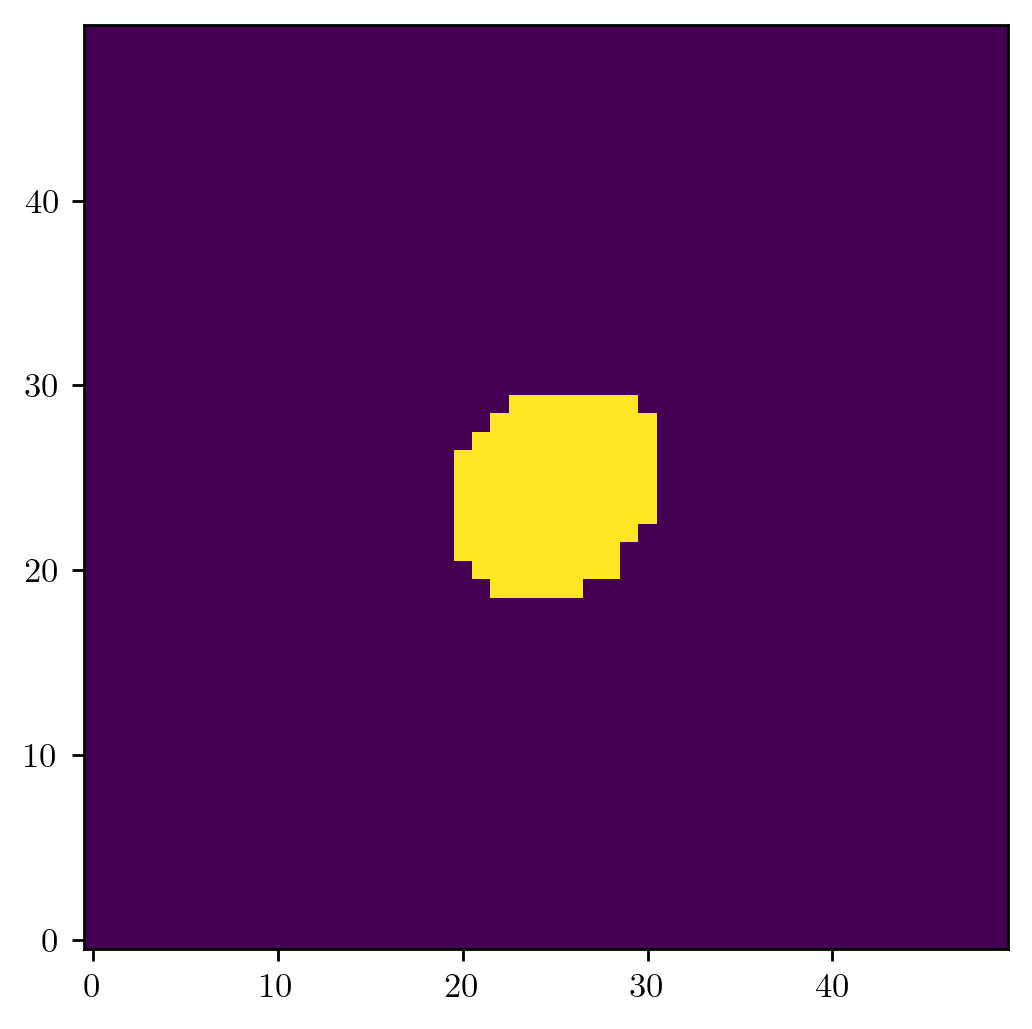

In [2]:
latex()

plt.imshow(pix_mask, origin='lower')

In [3]:
# Go into each pixel's h5 file and store relevant data from BAGPIPES
fit_instructions = build_dbl_power_law_fit_instructions(z)
sampler = 'multinest'

sfh = np.zeros((Npix, 3, 1654))
ages = np.zeros((Npix, 1654))
sfr100 = np.zeros((Npix, 3))
tMW = np.zeros((Npix, 3))
Av = np.zeros((Npix, 3))
ssfr = np.zeros((Npix, 3))
st_mass = np.zeros((Npix, 3))
logU = np.zeros((Npix, 3))
metallicity = np.zeros((Npix, 3))
burst = np.zeros((Npix, 3))


for i in range(Npix):
    # Run BAGPIPES on one pixel
    pixel = bp.galaxy(pixids[i], load_data, spectrum_exists=False, filt_list=filt_list, photometry_exists=True)

    fit = bp.fit(pixel, fit_instructions, run=run_name)
    fit.fit(verbose=True, sampler=sampler)

    # fit.posterior.get_advanced_quantities()
    ages[i, :] = fit.posterior.sfh.ages[:1654]
    sfh[i, :, :1654] = np.percentile(fit.posterior.samples['sfh'], [16, 50, 84], axis=0) # Star formation history (SFR [Msun/yr] vs time)
    sfr100[i, :] = np.percentile(fit.posterior.samples['sfr'], [16, 50, 84], axis=0)
    tMW[i, :] = np.percentile(fit.posterior.samples['mass_weighted_age'], [16, 50, 84], axis=0)
    Av[i, :] = np.percentile(fit.posterior.samples['dust:Av'], [16, 50, 84], axis=0)
    ssfr[i, :] = np.percentile(fit.posterior.samples['ssfr'], [16, 50, 84], axis=0)
    st_mass[i, :] = np.percentile(fit.posterior.samples['stellar_mass'], [16, 50, 84], axis=0)
    logU[i, :] = np.percentile(fit.posterior.samples['nebular:logU'], [16, 50, 84], axis=0)
    metallicity[i, :] = np.percentile(fit.posterior.samples['dblplaw:metallicity'], [16, 50, 84], axis=0)

    # x is in DECREASING order
    test_sfh = sfh[i, :, :]
    x = sfr_x_axis(ages[i, :], z) # Age of Universe in Gyr
    x_Myr = x*1e+3
    x_obs = x_Myr[0] # Epoch of observation
    sfr10 = np.average(test_sfh[:, x_Myr > (x_obs - 10)], axis=1)
    sfr90 = np.average(test_sfh[:, (x_Myr < (x_obs - 10)) & (x_Myr > (x_obs - 100))], axis=1)
    burst[i, :] = sfr10 / sfr90

/home/tdshield/miniconda3/envs/research/lib/python3.12/site-packages/bagpipes/models/star_formation_history.py:278: RuntimeWarning: overflow encountered in power
  sfr[mask] = ((t/tau)**alpha + (t/tau)**-beta)**-1



Results loaded from pipes/posterior/1obj_117602/0.h5

Fitting not performed as results have already been loaded from pipes/posterior/1obj_117602/0.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/1obj_117602/1.h5

Fitting not performed as results have already been loaded from pipes/posterior/1obj_117602/1.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/1obj_117602/2.h5

Fitting not performed as results have already been loaded from pipes/posterior/1obj_117602/2.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/1obj_117602/3.h5

Fitting not performed as results have already been loaded from pipes/posterior/1obj_117602/3.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/1obj_117602/4.h5

Fitting not performed as results have already been loaded from pipes/posterior/1obj_117602/4.h5. To start over delete this file or change run.


Resu

[]

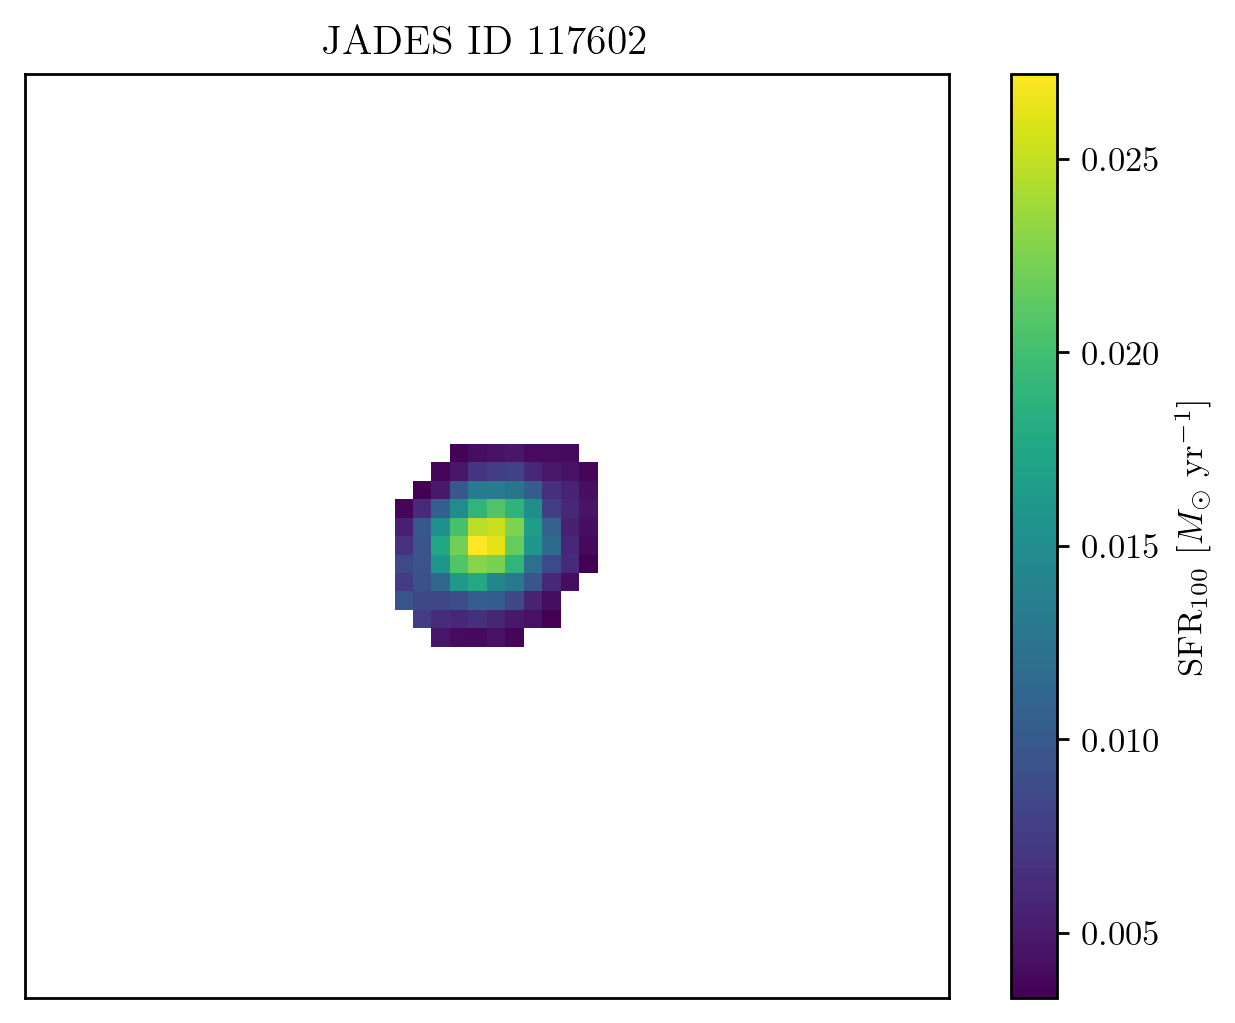

In [4]:
# SFR100
sfr_map = np.zeros((Ncut, Ncut))
sfr_map[pix_mask] = sfr100[:, 1]
sfr_map[~pix_mask] = np.nan

latex()
fig, ax = plt.subplots()
im = ax.imshow(sfr_map, origin='lower')

# Colorbar
cbar = fig.colorbar(im)
cbar.set_label('SFR$_{100}$ [$M_{\\odot}$ yr$^{-1}$]')

plt.title(f'JADES ID {objid}')

ax.set_xticks([])
ax.set_yticks([])

[]

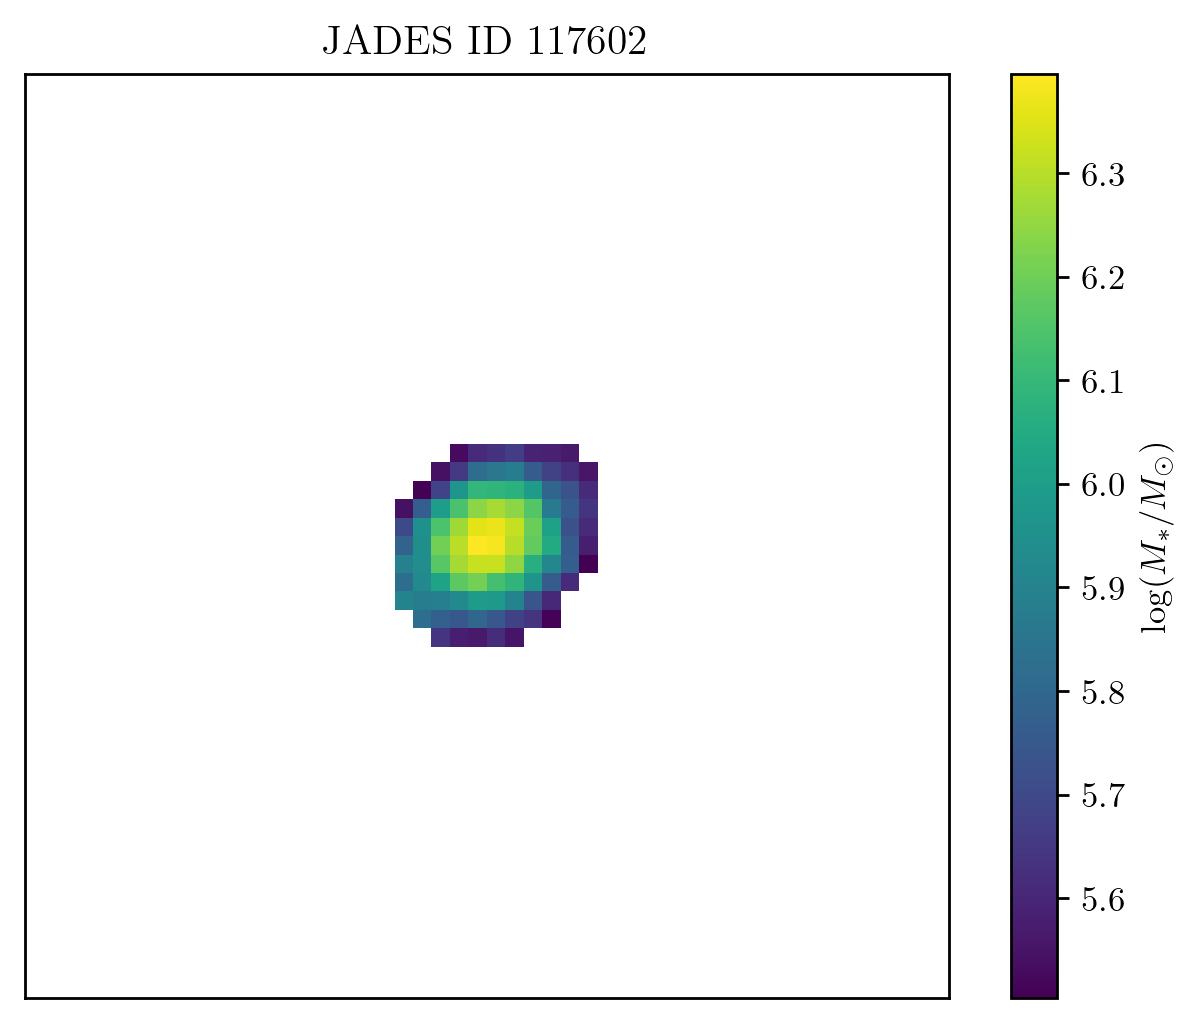

In [5]:
# Stellar mass
st_mass_map = np.zeros((Ncut, Ncut))
st_mass_map[pix_mask] = st_mass[:, 1]
st_mass_map[~pix_mask] = np.nan

latex()
fig, ax = plt.subplots()
im = ax.imshow(st_mass_map, origin='lower')

# Colorbar
cbar = fig.colorbar(im)
cbar.set_label('$\\log(M_{*} / M_{\\odot})$')

plt.title(f'JADES ID {objid}')

ax.set_xticks([])
ax.set_yticks([])

[]

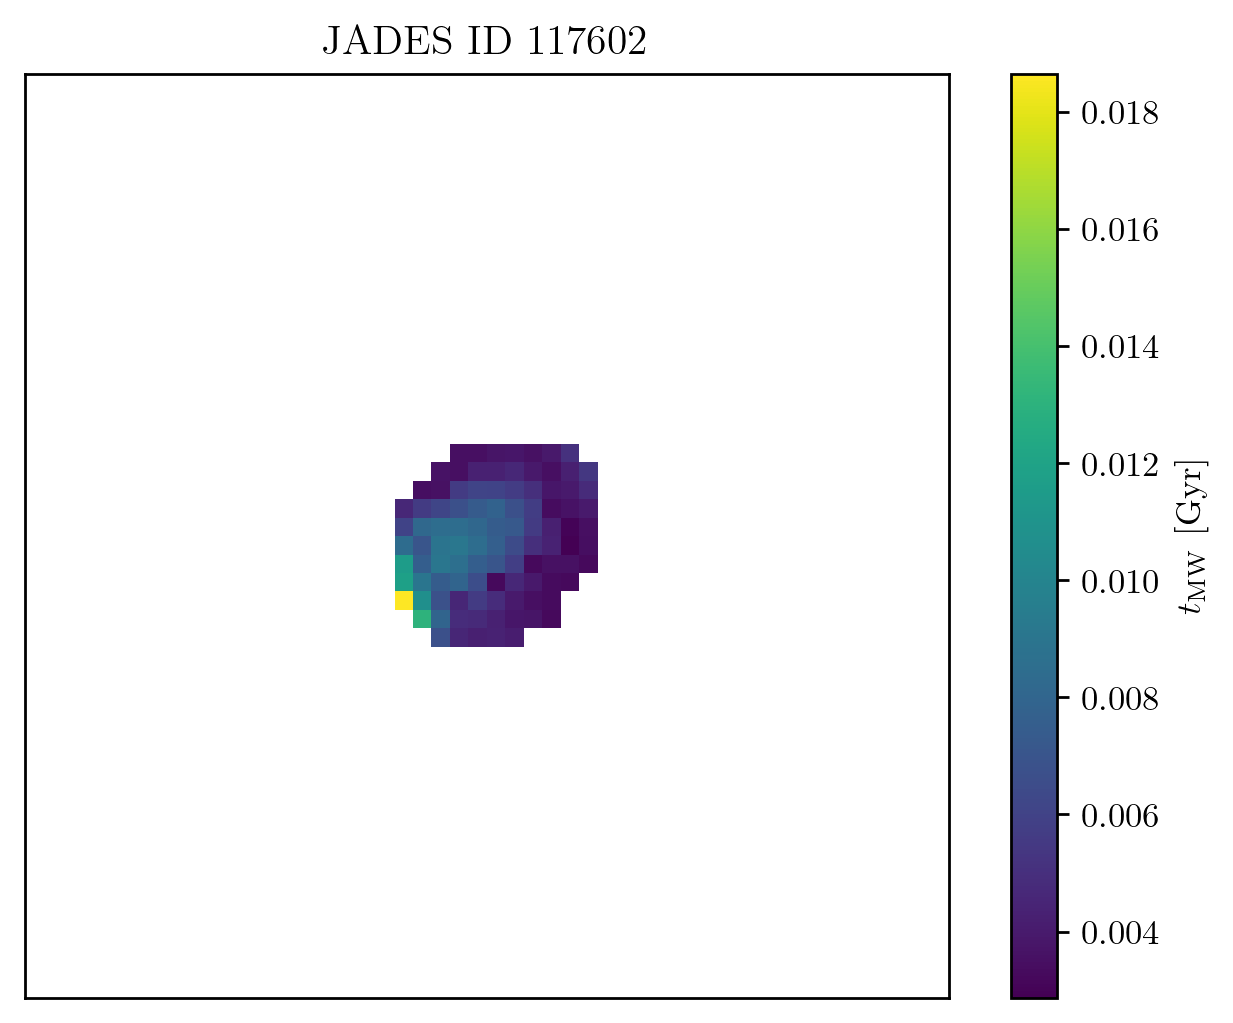

In [6]:
# Mass-weighted age
tMW_map = np.zeros((Ncut, Ncut))
tMW_map[pix_mask] = tMW[:, 1]
tMW_map[~pix_mask] = np.nan

latex()
fig, ax = plt.subplots()
im = ax.imshow(tMW_map, origin='lower')

# Colorbar
cbar = fig.colorbar(im)
cbar.set_label('$t_{\\rm MW}$ [Gyr]')

plt.title(f'JADES ID {objid}')

ax.set_xticks([])
ax.set_yticks([])

[]

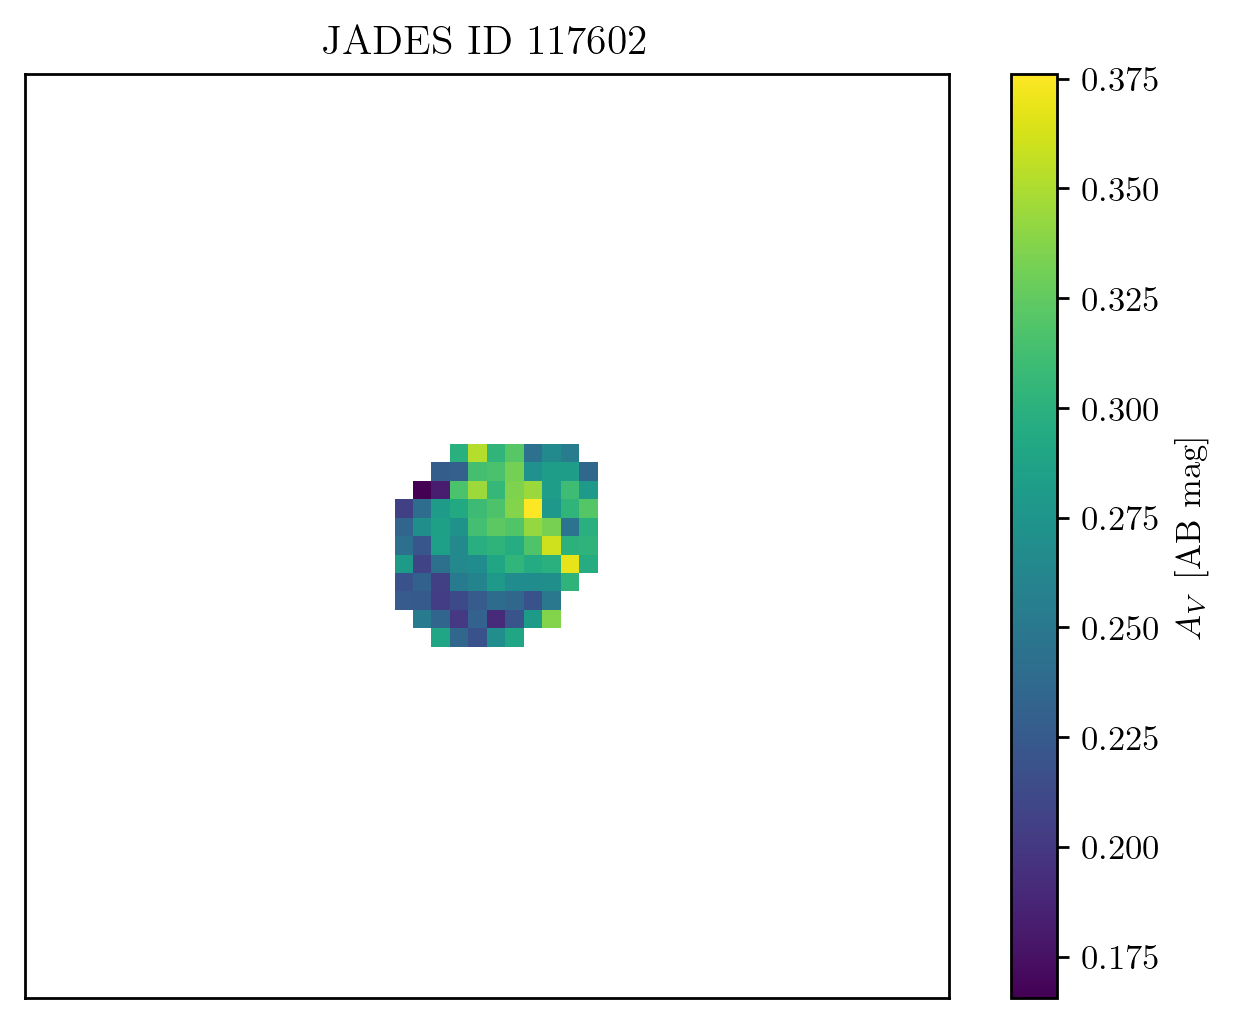

In [7]:
# Av
Av_map = np.zeros((Ncut, Ncut))
Av_map[pix_mask] = Av[:, 1]
Av_map[~pix_mask] = np.nan

latex()
fig, ax = plt.subplots()
im = ax.imshow(Av_map, origin='lower')

# Colorbar
cbar = fig.colorbar(im)
cbar.set_label('$A_V$ [AB mag]')

plt.title(f'JADES ID {objid}')

ax.set_xticks([])
ax.set_yticks([])

[]

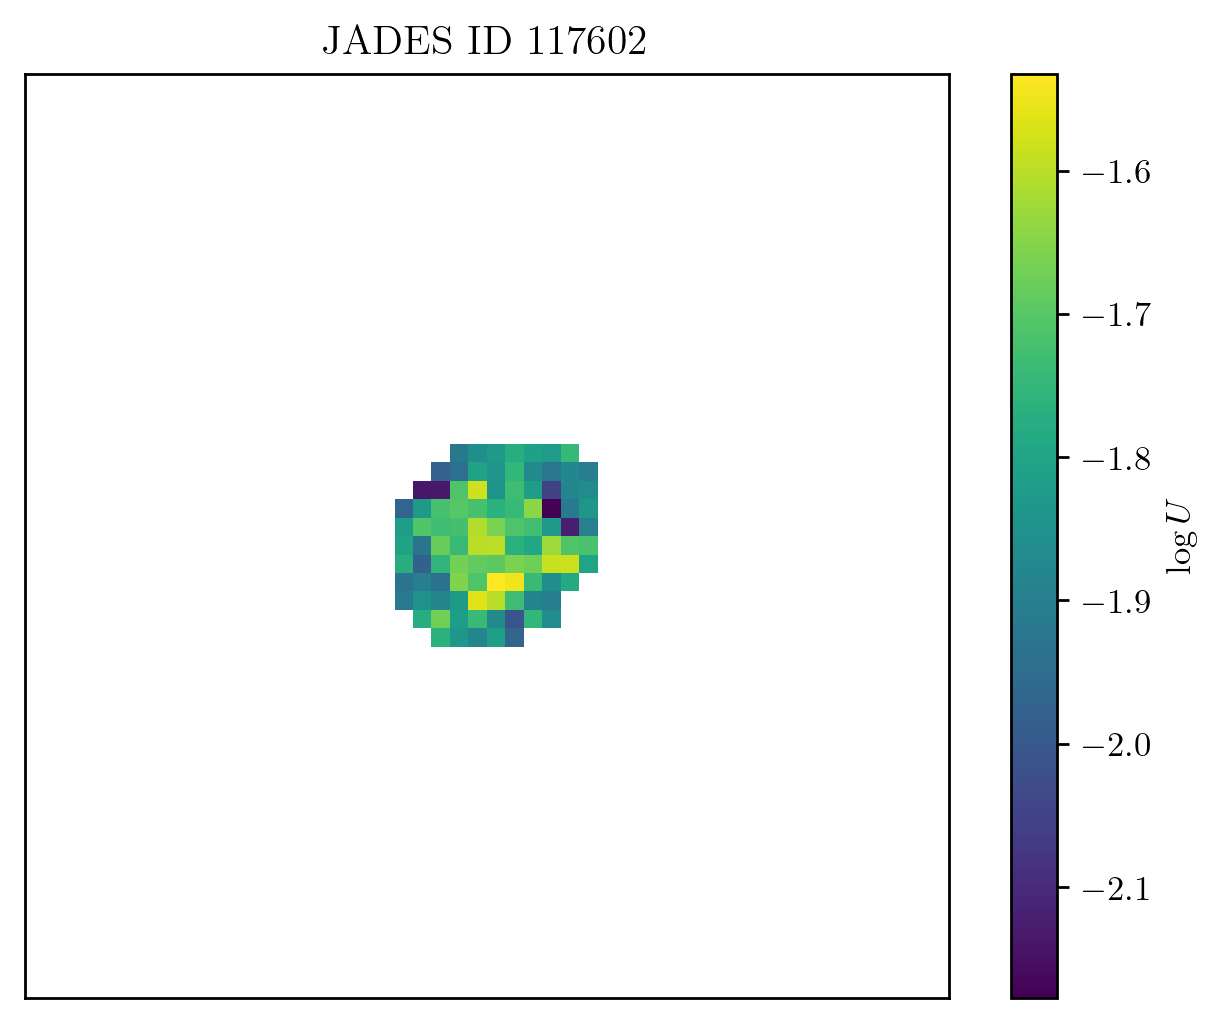

In [8]:
# logU
logU_map = np.zeros((Ncut, Ncut))
logU_map[pix_mask] = logU[:, 1]
logU_map[~pix_mask] = np.nan

latex()
fig, ax = plt.subplots()
im = ax.imshow(logU_map, origin='lower')

# Colorbar
cbar = fig.colorbar(im)
cbar.set_label('$\\log U$')

plt.title(f'JADES ID {objid}')

ax.set_xticks([])
ax.set_yticks([])

[]

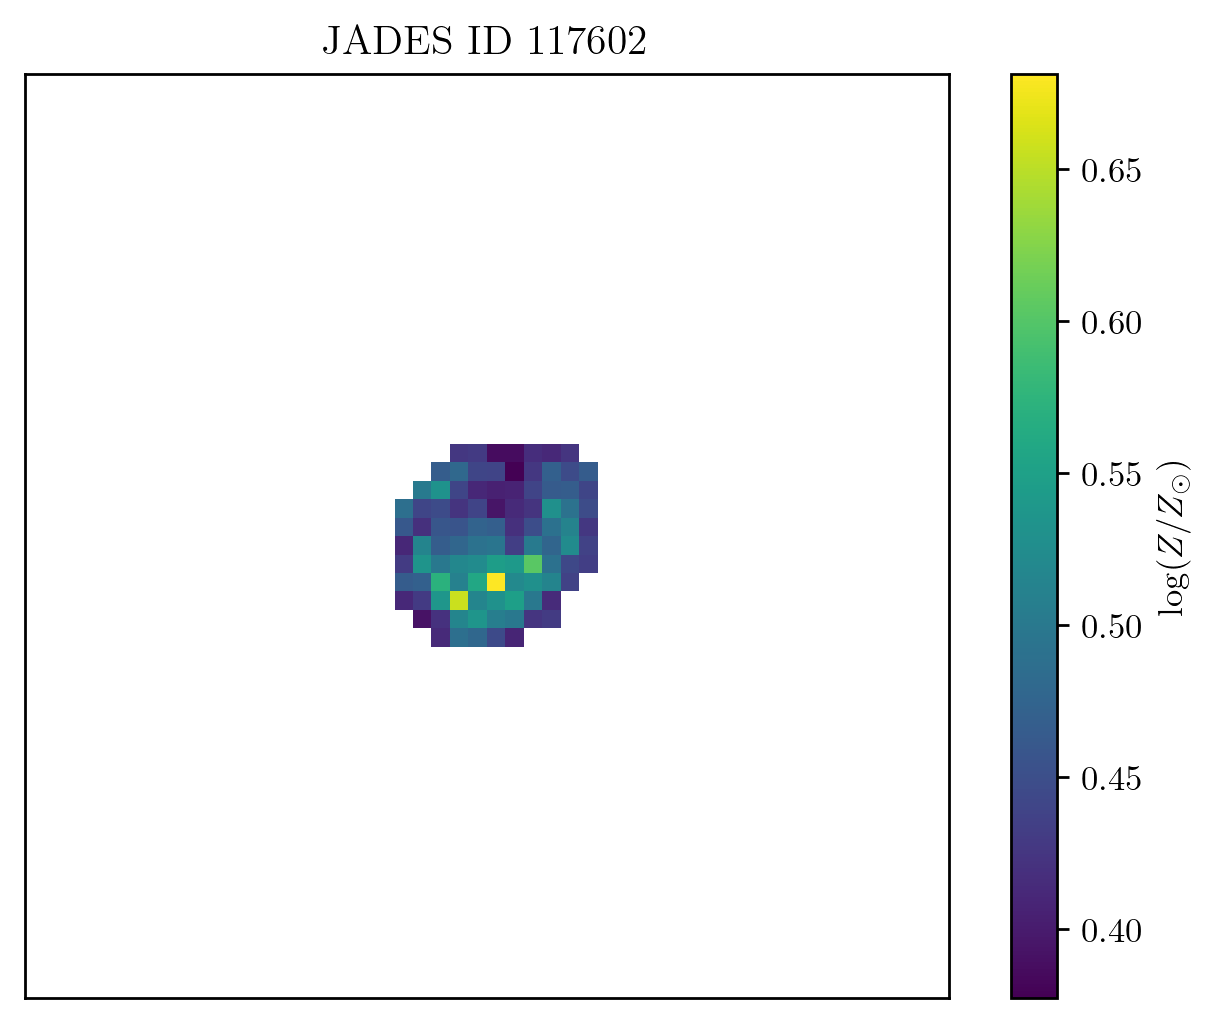

In [9]:
# metallicity
metallicity_map = np.zeros((Ncut, Ncut))
metallicity_map[pix_mask] = metallicity[:, 1]
metallicity_map[~pix_mask] = np.nan

latex()
fig, ax = plt.subplots()
im = ax.imshow(metallicity_map, origin='lower')

# Colorbar
cbar = fig.colorbar(im)
cbar.set_label('$\\log(Z/Z_{\\odot})$')

plt.title(f'JADES ID {objid}')

ax.set_xticks([])
ax.set_yticks([])

[]

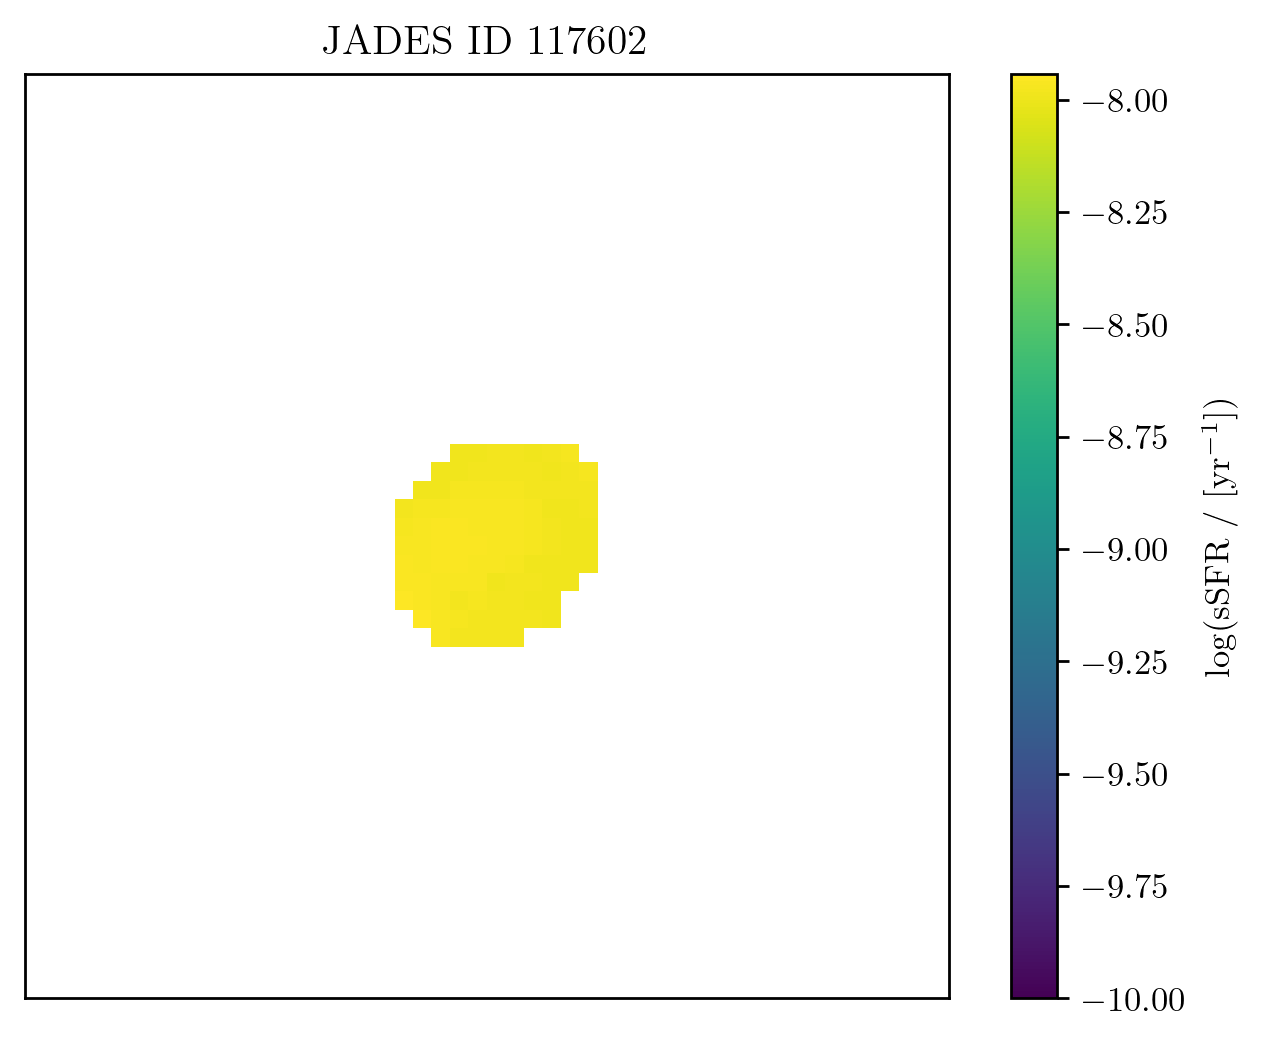

In [10]:
# sSFR
ssfr_map = np.zeros((Ncut, Ncut))
ssfr_map[pix_mask] = ssfr[:, 1]
ssfr_map[~pix_mask] = np.nan

latex()
fig, ax = plt.subplots()
im = ax.imshow(ssfr_map, origin='lower', vmin=-10)

# Colorbar
cbar = fig.colorbar(im)
cbar.set_label('$\\log$(sSFR / [yr$^{-1}$])')

plt.title(f'JADES ID {objid}')

ax.set_xticks([])
ax.set_yticks([])

Text(0.5, 1.0, '84th Percentile')

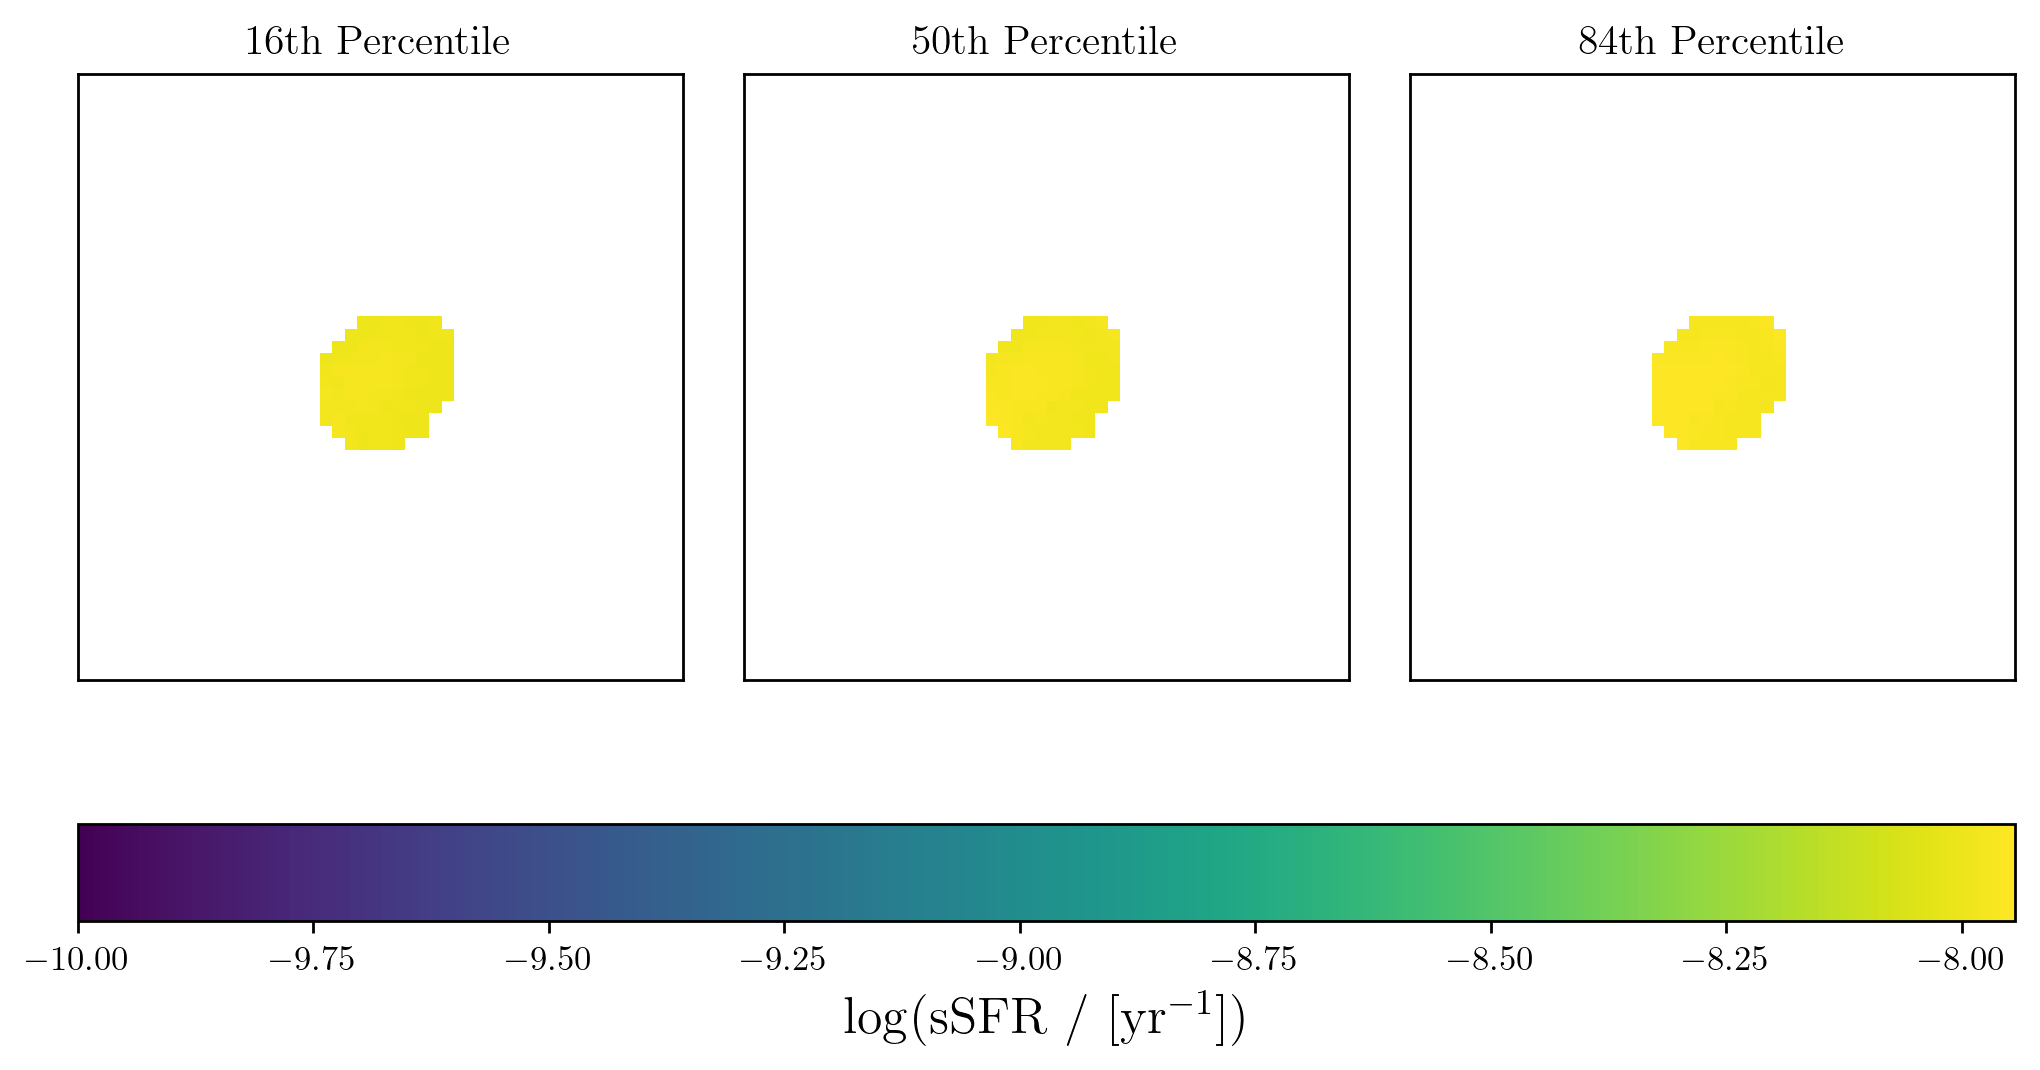

In [11]:
# sSFR
from matplotlib.colors import Normalize

norm = Normalize(vmin=-10, vmax=np.max(ssfr[:, 1]))

latex()
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
plt.subplots_adjust(wspace=0.1)

for i in range(3):
    ssfr_map = np.zeros((Ncut, Ncut))
    ssfr_map[pix_mask] = ssfr[:, i]
    ssfr_map[~pix_mask] = np.nan
    im = axes[i].imshow(ssfr_map, origin='lower', norm=norm)

    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal')
cbar.set_label('$\\log$(sSFR / [yr$^{-1}$])', fontsize=15)

# axes[1].set_title(f'JADES ID {objid}')
axes[0].set_title('16th Percentile')
axes[1].set_title('50th Percentile')
axes[2].set_title('84th Percentile')

Text(0.5, 1.0, '84th Percentile')

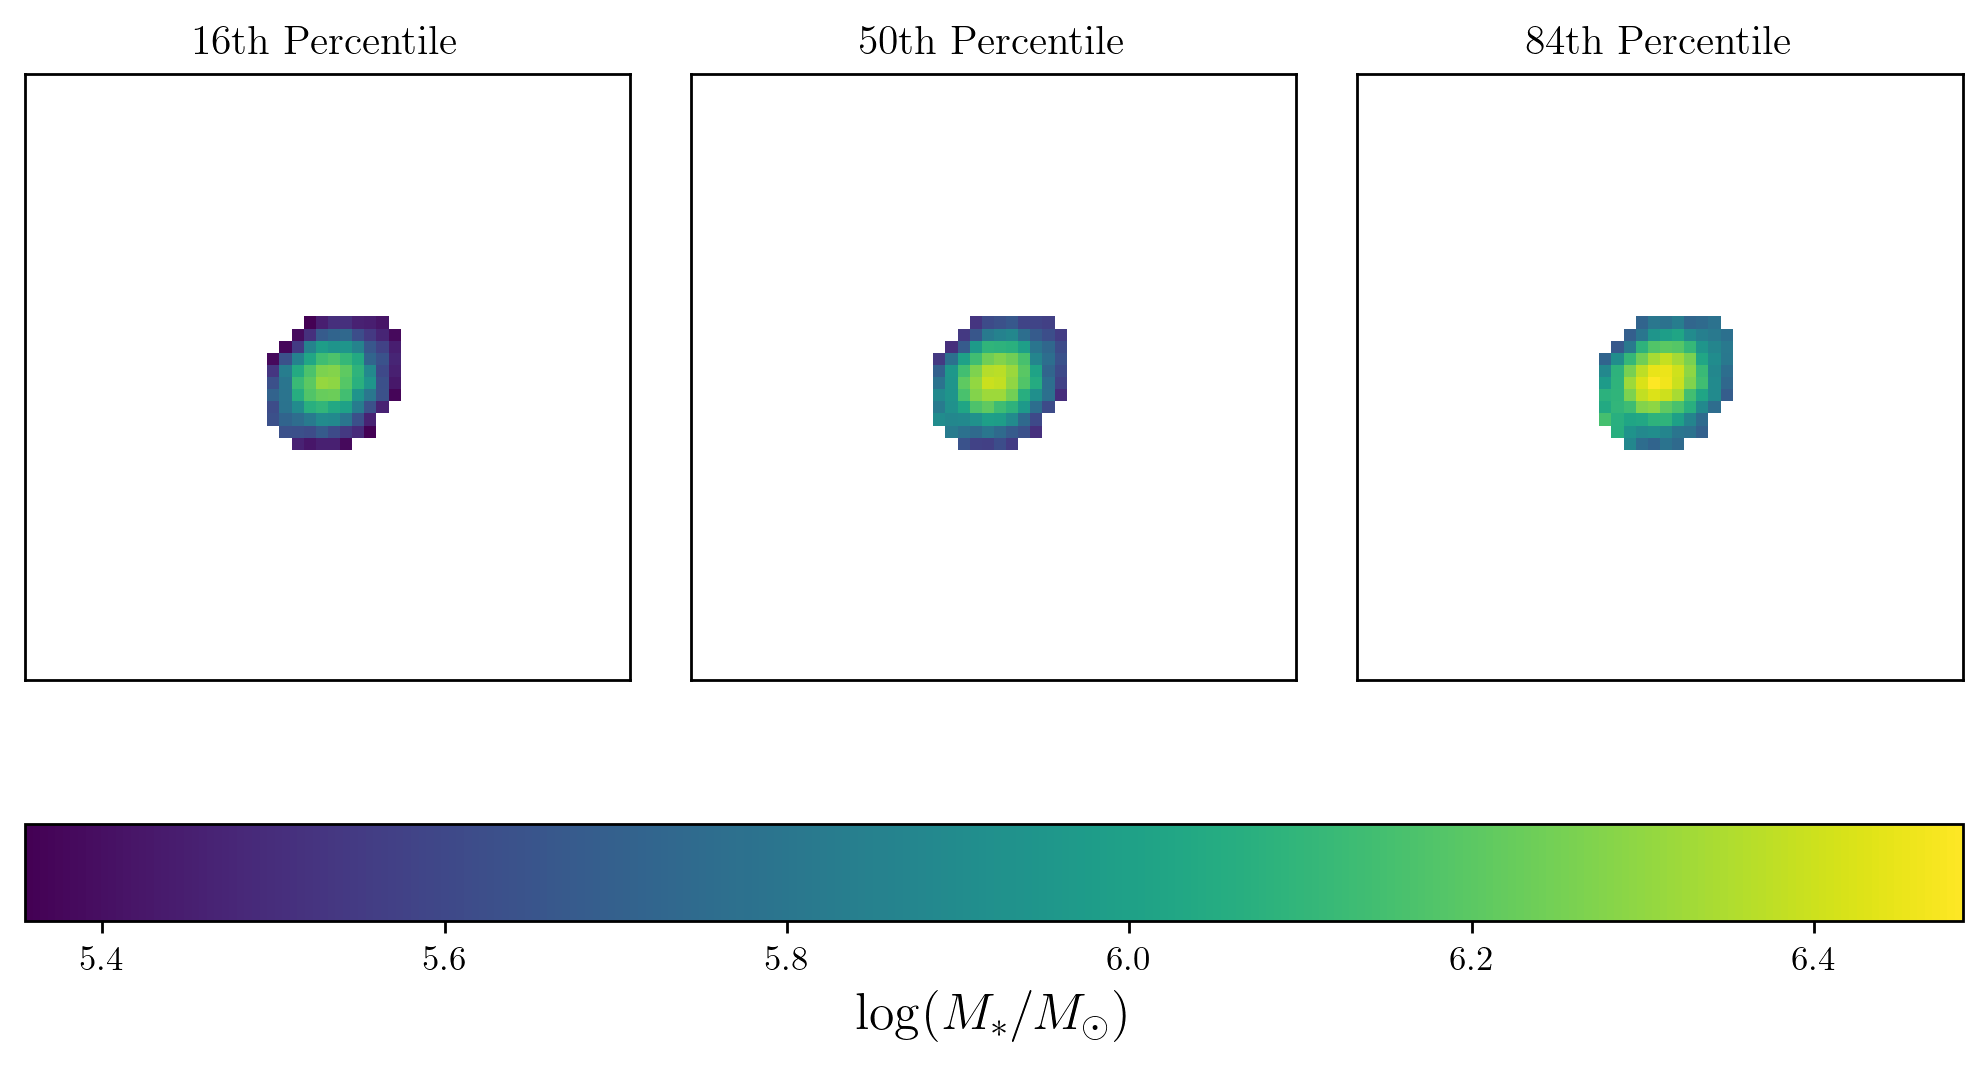

In [12]:
# Stellar mass
norm = Normalize(vmin=np.min(st_mass), vmax=np.max(st_mass))

latex()
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
plt.subplots_adjust(wspace=0.1)

for i in range(3):
    st_mass_map = np.zeros((Ncut, Ncut))
    st_mass_map[pix_mask] = st_mass[:, i]
    st_mass_map[~pix_mask] = np.nan
    im = axes[i].imshow(st_mass_map, origin='lower', norm=norm)

    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal')
cbar.set_label('$\\log(M_* / M_{\\odot})$', fontsize=15)

# axes[1].set_title(f'JADES ID {objid}')
axes[0].set_title('16th Percentile')
axes[1].set_title('50th Percentile')
axes[2].set_title('84th Percentile')

Text(0.5, 1.0, '84th Percentile')

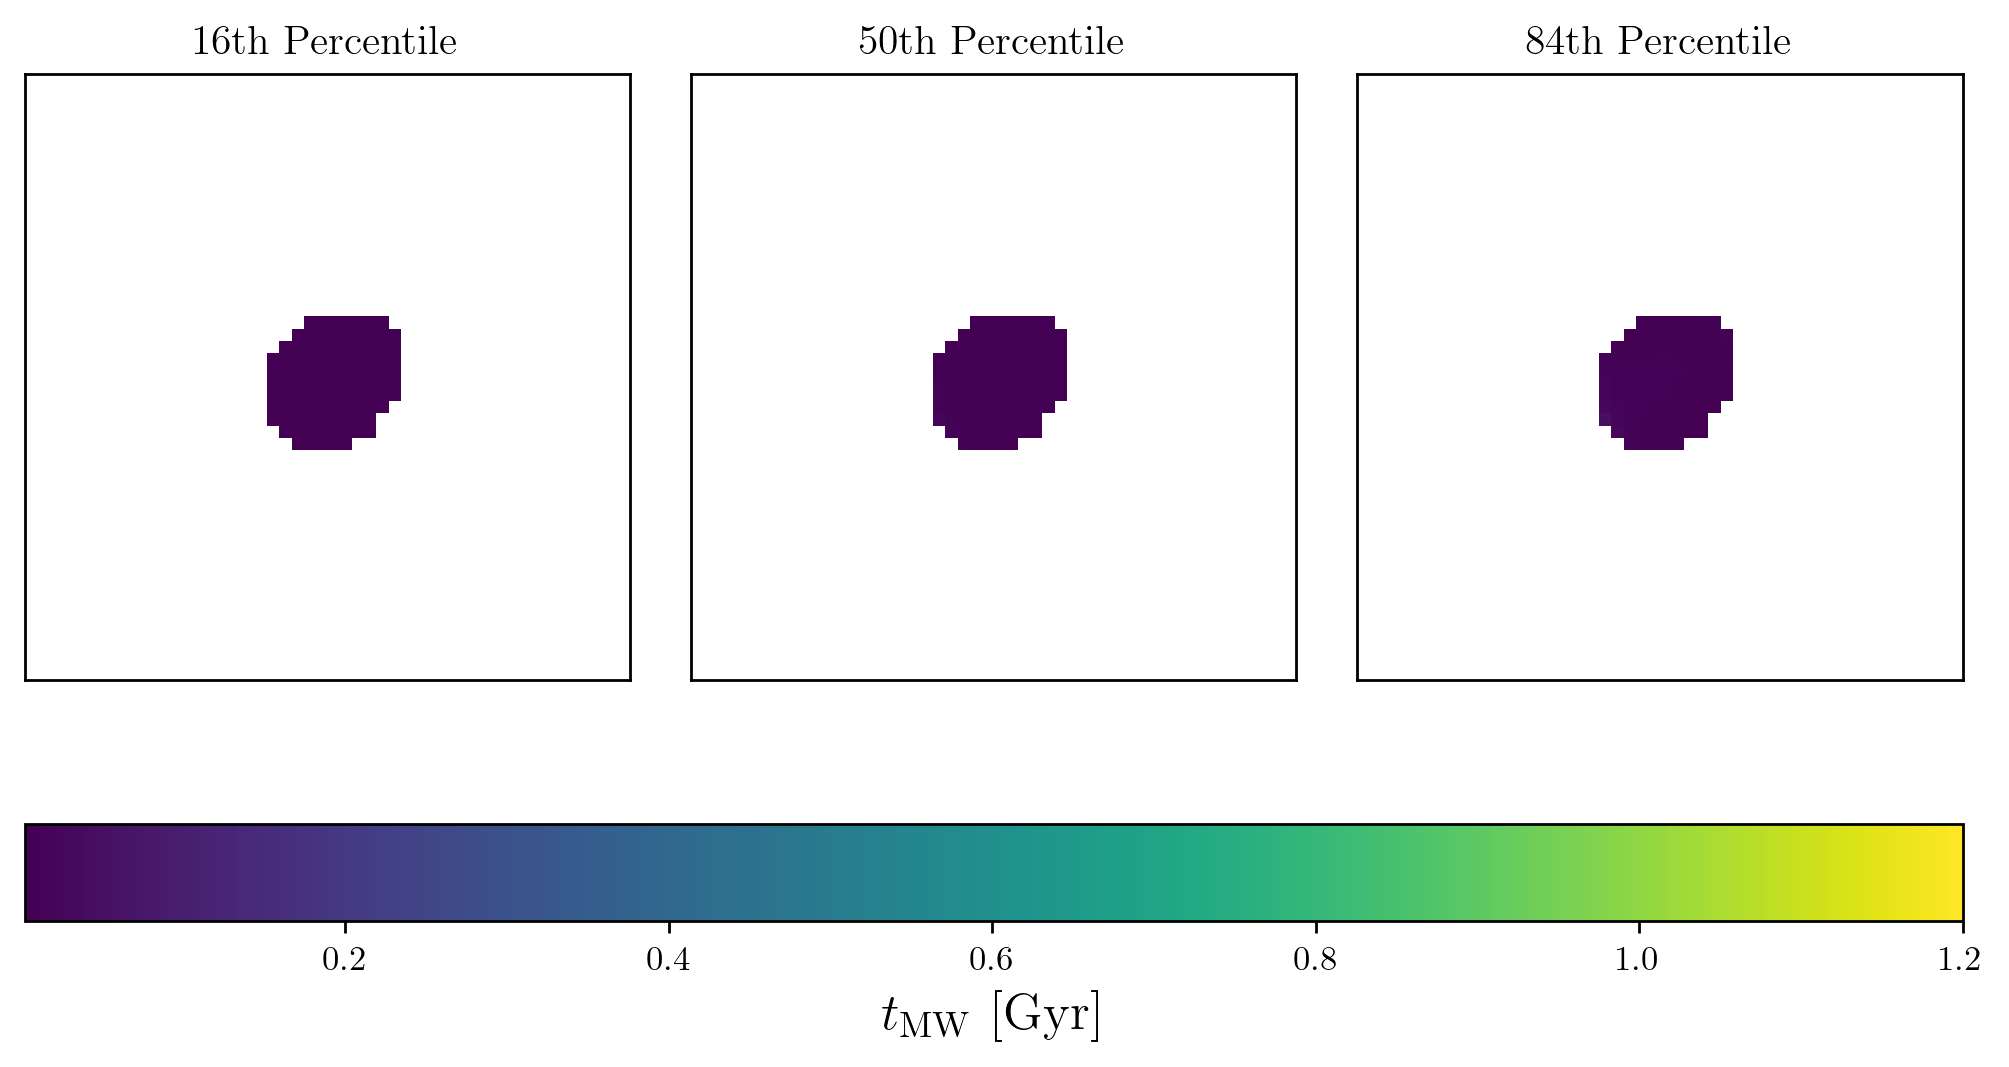

In [13]:
# Mass-weighted age
norm = Normalize(vmin=np.min(tMW), vmax=1.2)

latex()
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
plt.subplots_adjust(wspace=0.1)

for i in range(3):
    tMW_map = np.zeros((Ncut, Ncut))
    tMW_map[pix_mask] = tMW[:, i]
    tMW_map[~pix_mask] = np.nan
    im = axes[i].imshow(tMW_map, origin='lower', norm=norm)

    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal')
cbar.set_label('$t_{\\rm MW}$ [Gyr]', fontsize=15)

# axes[1].set_title(f'JADES ID {objid}')
axes[0].set_title('16th Percentile')
axes[1].set_title('50th Percentile')
axes[2].set_title('84th Percentile')

Text(0.5, 1.0, '84th Percentile')

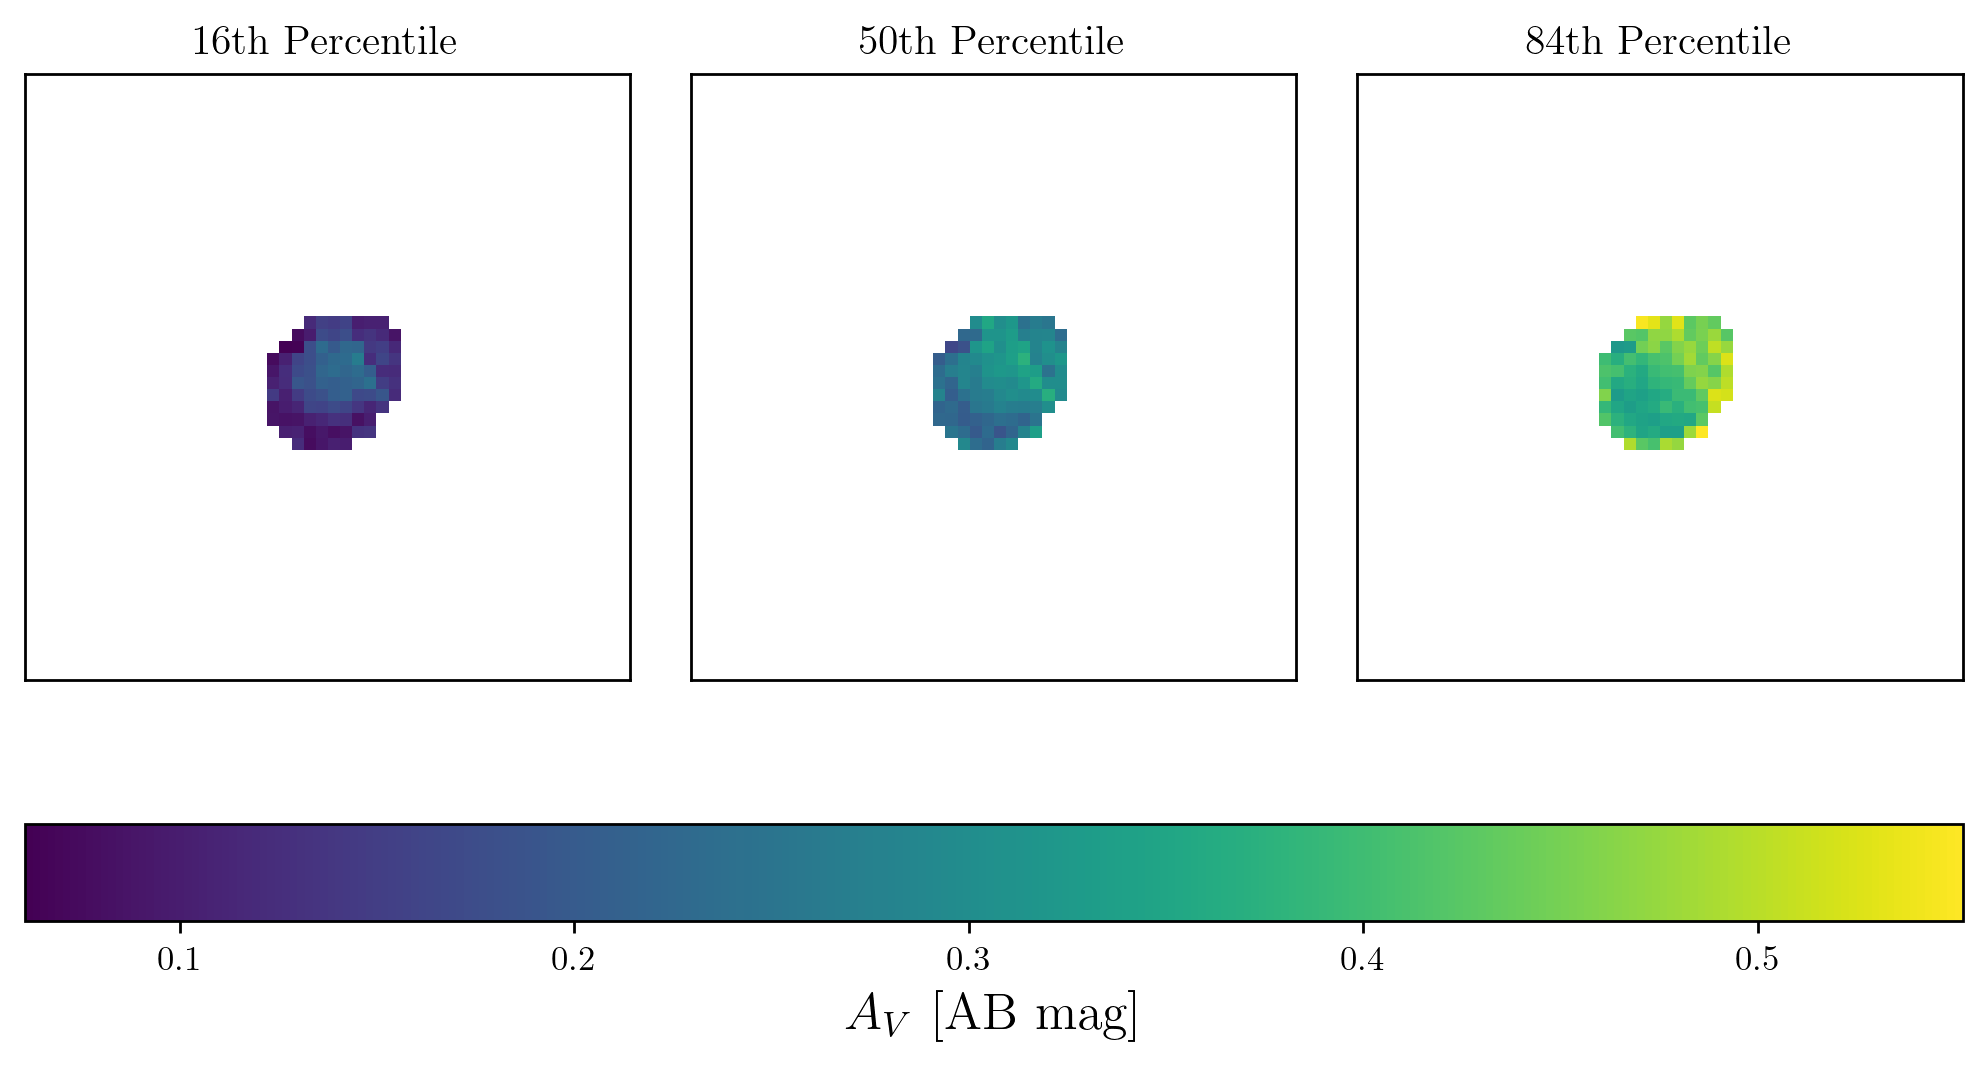

In [14]:
# Dust attenuation (V-band)
norm = Normalize(vmin=np.min(Av), vmax=np.max(Av))

latex()
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
plt.subplots_adjust(wspace=0.1)

for i in range(3):
    Av_map = np.zeros((Ncut, Ncut))
    Av_map[pix_mask] = Av[:, i]
    Av_map[~pix_mask] = np.nan
    im = axes[i].imshow(Av_map, origin='lower', norm=norm)

    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal')
cbar.set_label('$A_V$ [AB mag]', fontsize=15)

# axes[1].set_title(f'JADES ID {objid}')
axes[0].set_title('16th Percentile')
axes[1].set_title('50th Percentile')
axes[2].set_title('84th Percentile')

Text(0.5, 1.0, '84th Percentile')

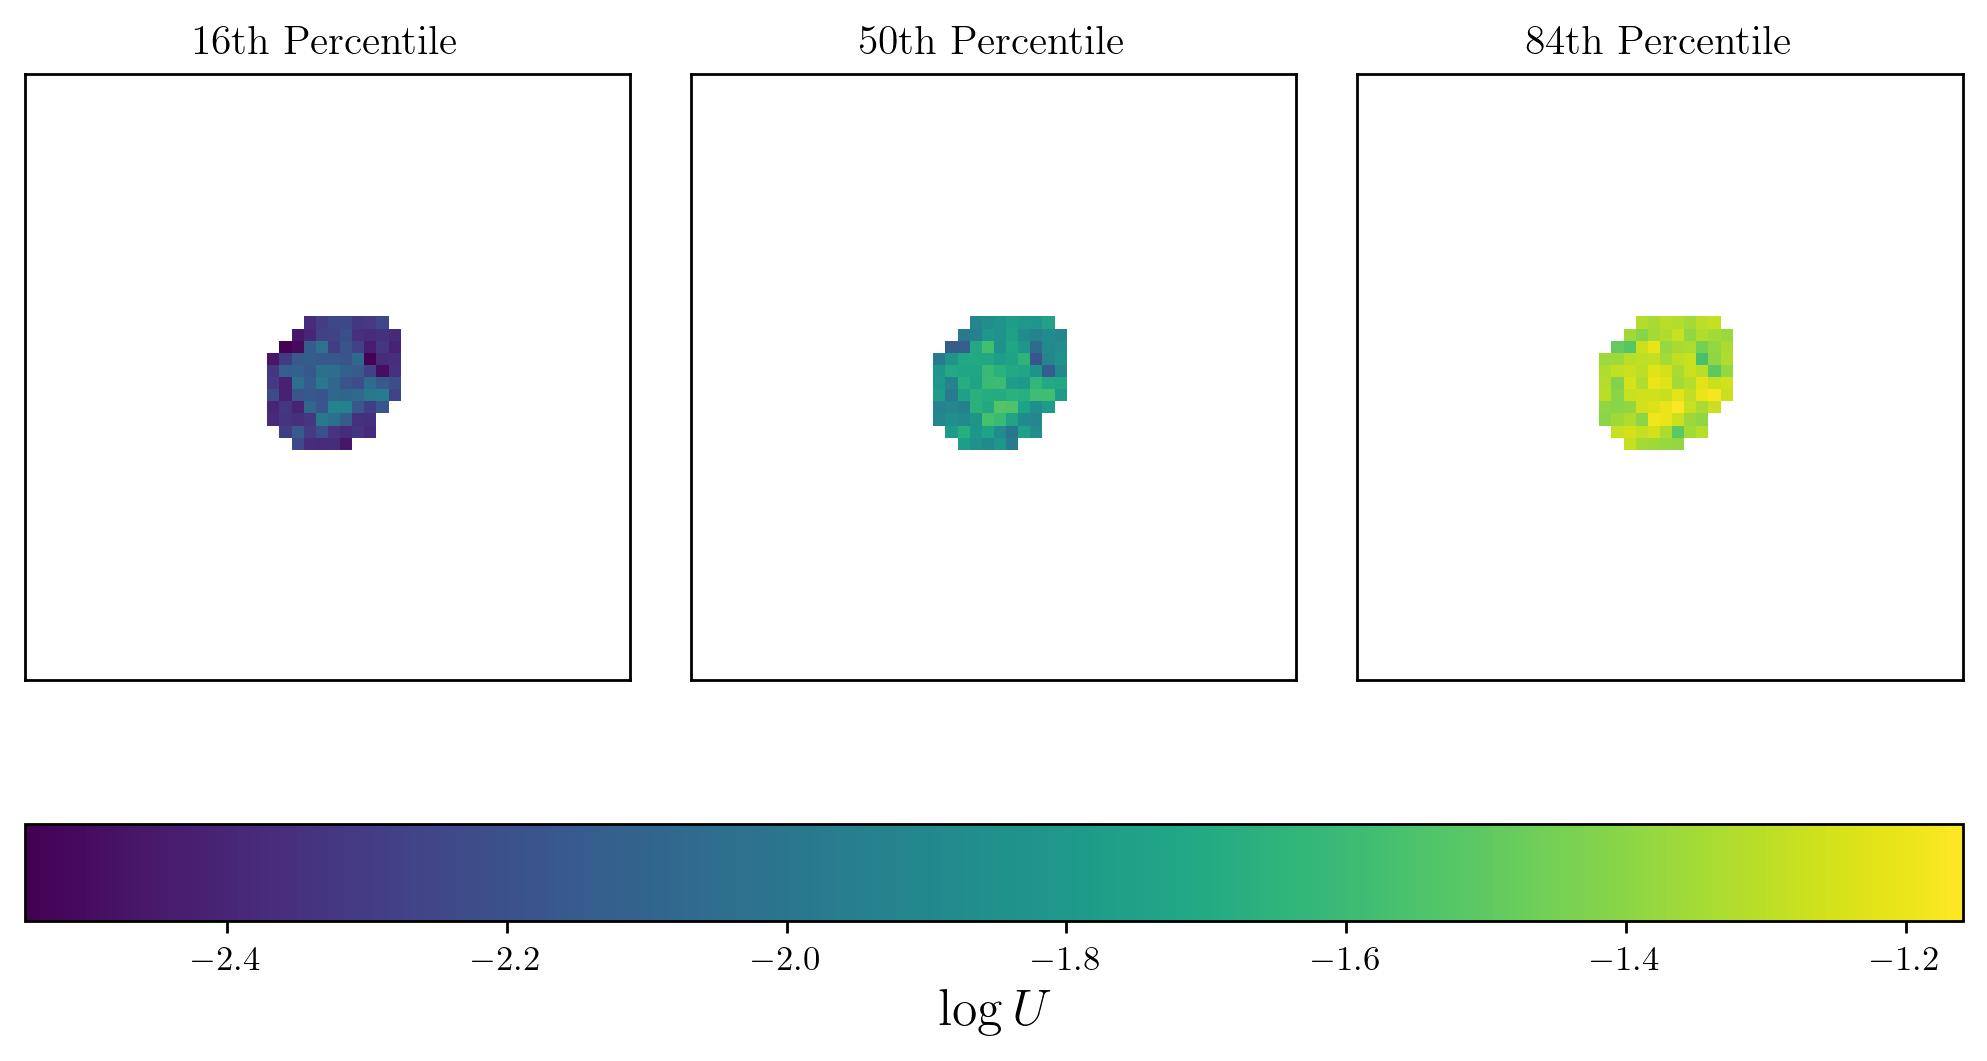

In [15]:
# logU
norm = Normalize(vmin=np.min(logU), vmax=np.max(logU))

latex()
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
plt.subplots_adjust(wspace=0.1)

for i in range(3):
    logU_map = np.zeros((Ncut, Ncut))
    logU_map[pix_mask] = logU[:, i]
    logU_map[~pix_mask] = np.nan
    im = axes[i].imshow(logU_map, origin='lower', norm=norm)

    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal')
cbar.set_label('$\\log U$', fontsize=15)

# axes[1].set_title(f'JADES ID {objid}')
axes[0].set_title('16th Percentile')
axes[1].set_title('50th Percentile')
axes[2].set_title('84th Percentile')

Text(0.5, 1.0, '84th Percentile')

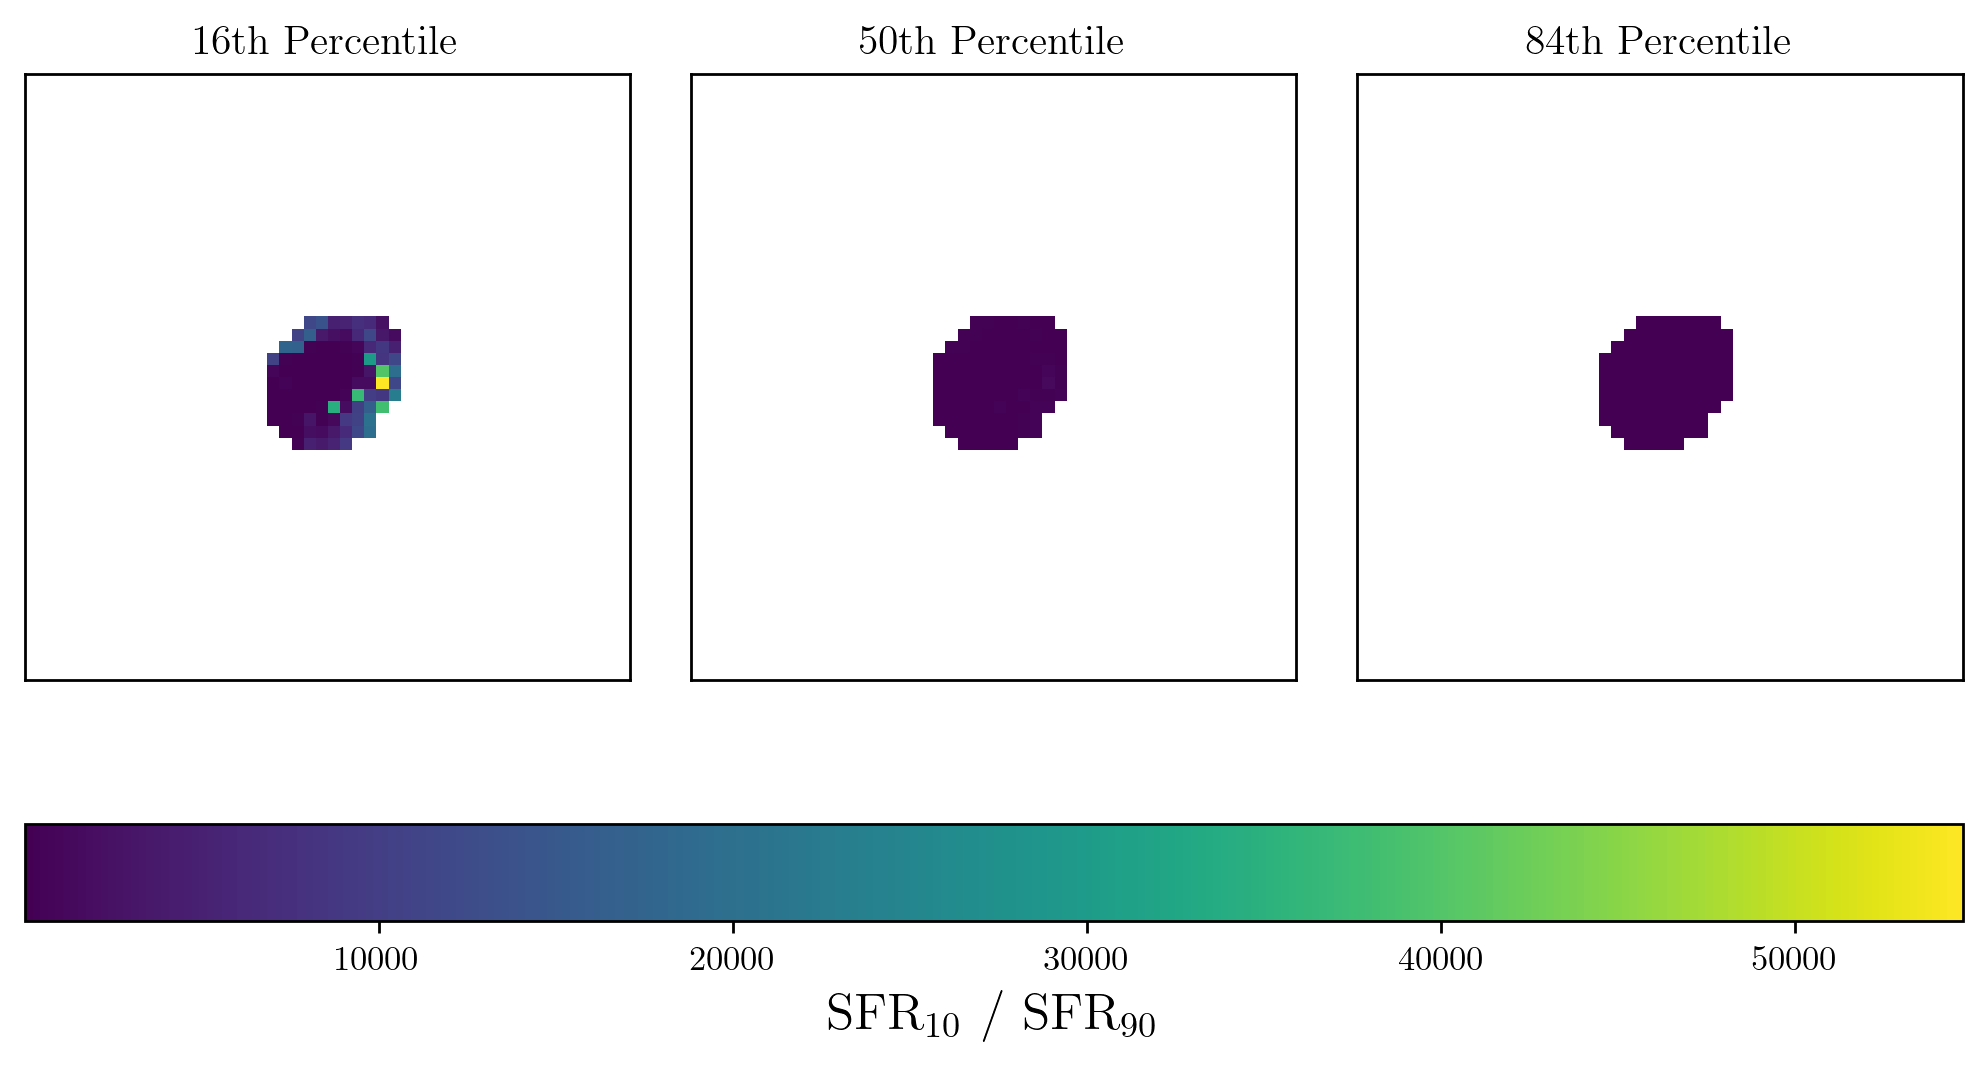

In [16]:
# BURSTINESS
norm = Normalize(vmin=np.min(burst), vmax=np.max(burst))

latex()
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
plt.subplots_adjust(wspace=0.1)

for i in range(3):
    burst_map = np.zeros((Ncut, Ncut))
    burst_map[pix_mask] = burst[:, i]
    burst_map[~pix_mask] = np.nan
    im = axes[i].imshow(burst_map, origin='lower', norm=norm)

    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal')
cbar.set_label('SFR$_{10}$ / SFR$_{90}$', fontsize=15)

# axes[1].set_title(f'JADES ID {objid}')
axes[0].set_title('16th Percentile')
axes[1].set_title('50th Percentile')
axes[2].set_title('84th Percentile')

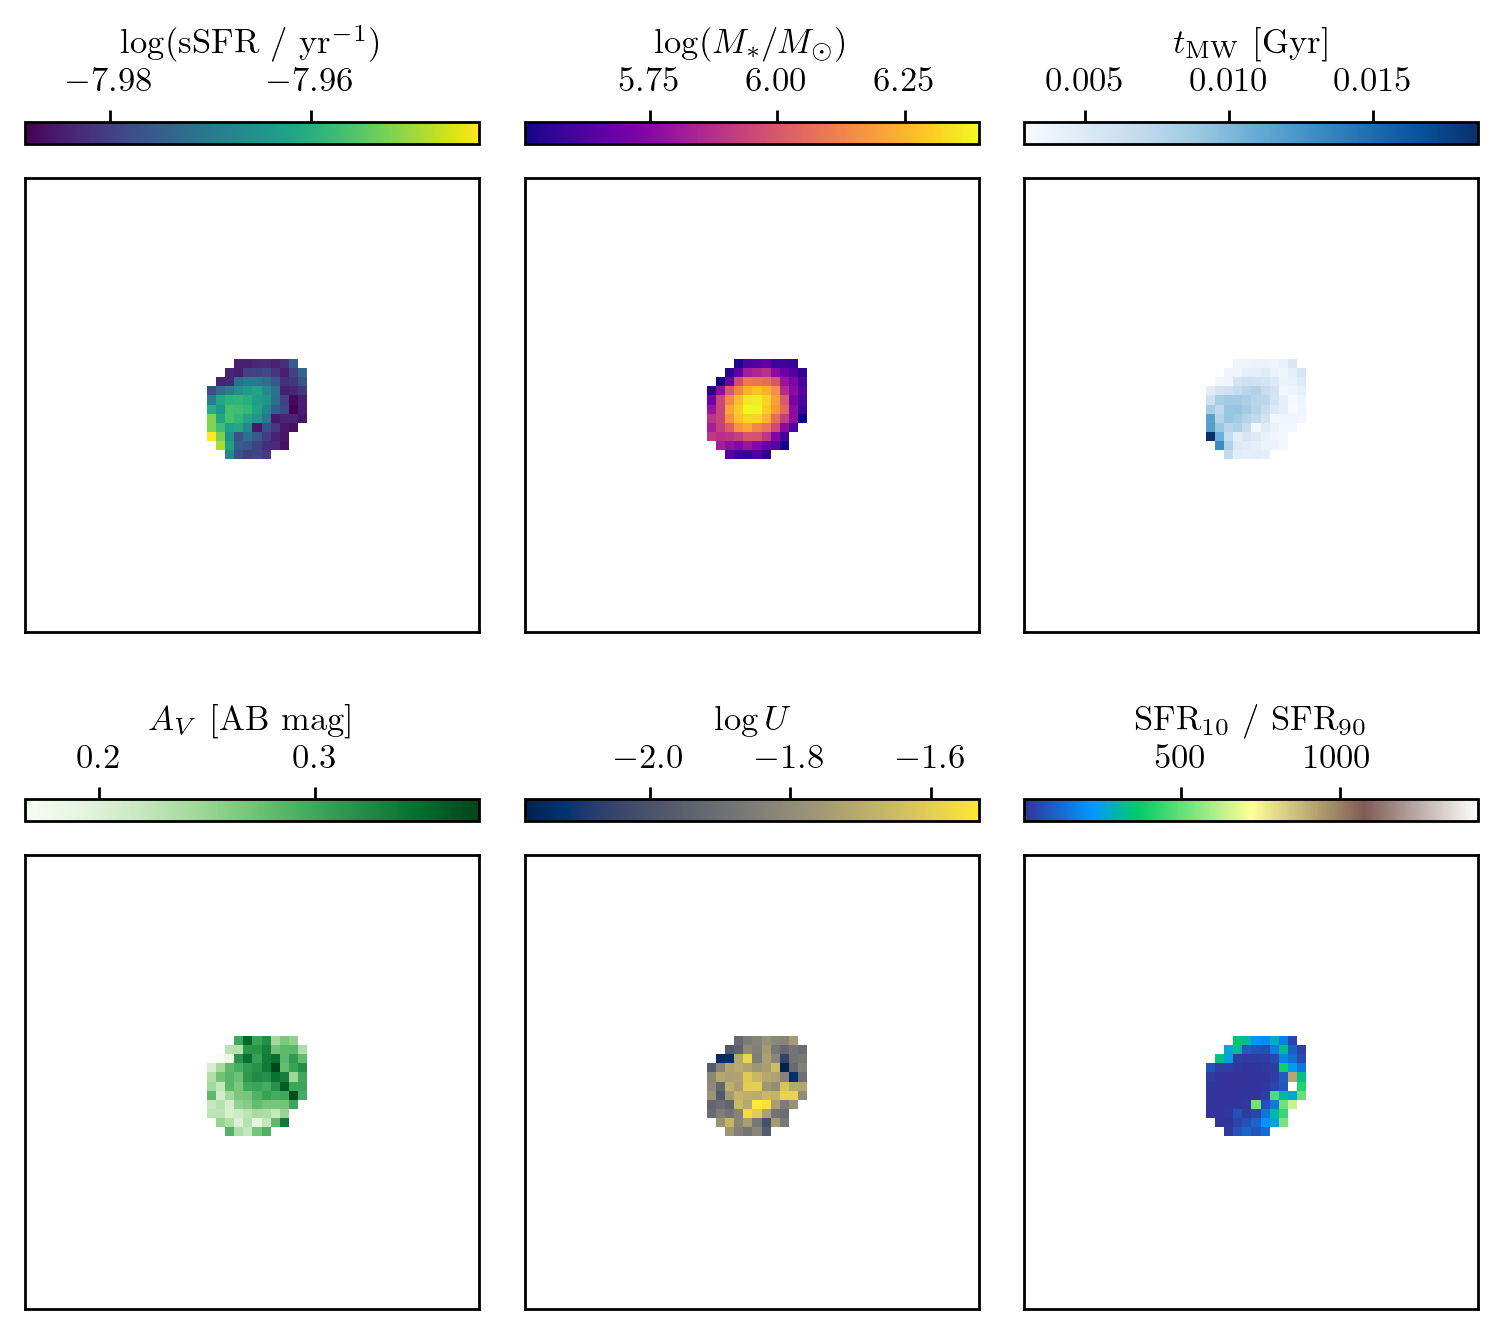

In [24]:
# Six-panel summary plot
property_arrays = [ssfr, st_mass, tMW, Av, logU, burst]
property_labels = ['$\\log$(sSFR / yr$^{-1}$)', '$\\log(M_*/M_{\\odot})$', '$t_{\\rm MW}$ [Gyr]', '$A_V$ [AB mag]', '$\\log U$', 
                   'SFR$_{10}$ / SFR$_{90}$']
cmaps = ['viridis', 'plasma', 'Blues', 'Greens', 'cividis', 'terrain']

latex()
fig, axes = plt.subplots(2, 3, figsize=(7.5, 7))
plt.subplots_adjust(hspace=0.01, wspace=0.1)

i = 0
for row in range(2):
    for col in range(3):
        # Stellar mass
        property_map = np.zeros((Ncut, Ncut))
        property_map[pix_mask] = property_arrays[i][:, 1]
        property_map[~pix_mask] = np.nan

        latex()
        # fig, ax = plt.subplots()
        
        if i == 0:
            im = axes[row, col].imshow(property_map, origin='lower', cmap=cmaps[i])
        elif i == 5:
            im = axes[row, col].imshow(property_map, origin='lower', cmap=cmaps[i])
        else:
            im = axes[row, col].imshow(property_map, origin='lower', cmap=cmaps[i])

        # im = axes[row, col].imshow(property_map, origin='lower', cmap=cmaps[i])

        # Colorbar
        cbar = fig.colorbar(im, location='top')
        cbar.set_label(property_labels[i])

        # plt.title(f'JADES ID {objid}')

        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])

        i += 1

Text(30, 0.2, 'F200W')

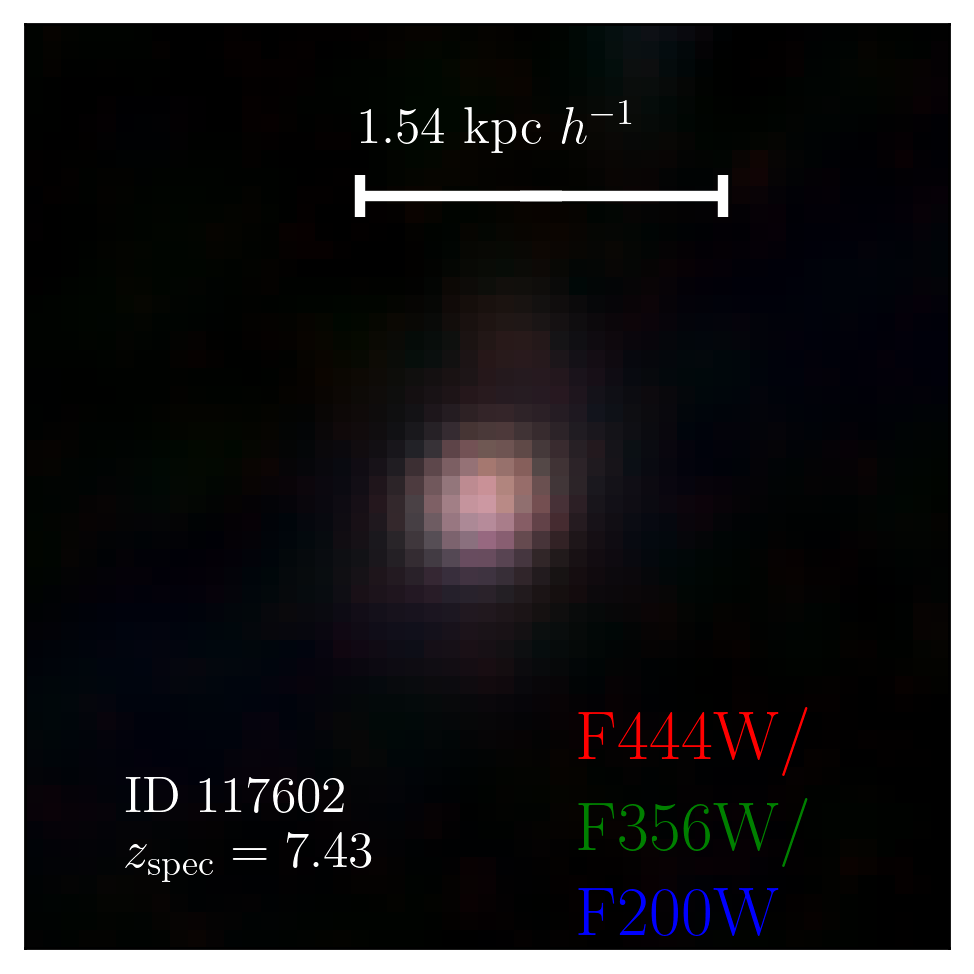

In [25]:
o = obj(objid)
# RGBs of the bursty galaxies
latex()

rgb, norm = o.plot_RGB(n=50, min_scale=0.0, r_filter='F444W', g_filter='F356W', b_filter='F200W', r_scale=1.0)
z = 7.430

Nrow, Ncol = 2, 6
fig, ax = plt.subplots()

phys_scale = cosmo.angular_diameter_distance(z) * 0.3 * (1 / 3600) * (np.pi / 180)
phys_scale = phys_scale.value * 1e+3 # kpc

ax.imshow(rgb, origin='lower', norm=norm)
ax.text(5, 7, f'$ \\rm ID \\; {{{str(int(objid))}}}$', fontsize=15, color='white')
ax.text(5, 4, f'$z_{{\\rm spec}} = {z:.2f}$', fontsize=15, color='white')
ax.errorbar(28, 41, xerr=+10.0, yerr=0, marker='none', markerfacecolor='red', markeredgecolor='red', color='white', lw=3, 
                        capsize=6.0, capthick=3.0)
ax.text(18, 44, f'${phys_scale:.2f}$' + ' kpc $h^{{-1}}$', color='white', fontsize=15)
ax.set_xticks([])
ax.set_yticks([])
ax.text(30, 10, 'F444W/', color='red', fontsize=20)
ax.text(30, 5, 'F356W/', color='green', fontsize=20)
ax.text(30, 0.2, 'F200W', color='blue', fontsize=20)

In [28]:
np.max(sfh)

0.544615214149444

frame 1/227 complete
frame 1/227 complete
frame 1/227 complete
frame 1/227 complete
frame 2/227 complete
frame 3/227 complete
frame 4/227 complete
frame 5/227 complete
frame 6/227 complete
frame 7/227 complete
frame 8/227 complete
frame 9/227 complete
frame 10/227 complete
frame 11/227 complete
frame 12/227 complete
frame 13/227 complete
frame 14/227 complete
frame 15/227 complete
frame 16/227 complete
frame 17/227 complete
frame 18/227 complete
frame 19/227 complete
frame 20/227 complete
frame 21/227 complete
frame 22/227 complete
frame 23/227 complete
frame 24/227 complete
frame 25/227 complete
frame 26/227 complete
frame 27/227 complete
frame 28/227 complete
frame 29/227 complete
frame 30/227 complete
frame 31/227 complete
frame 32/227 complete
frame 33/227 complete
frame 34/227 complete
frame 35/227 complete
frame 36/227 complete
frame 37/227 complete
frame 38/227 complete
frame 39/227 complete
frame 40/227 complete
frame 41/227 complete
frame 42/227 complete
frame 43/227 complete


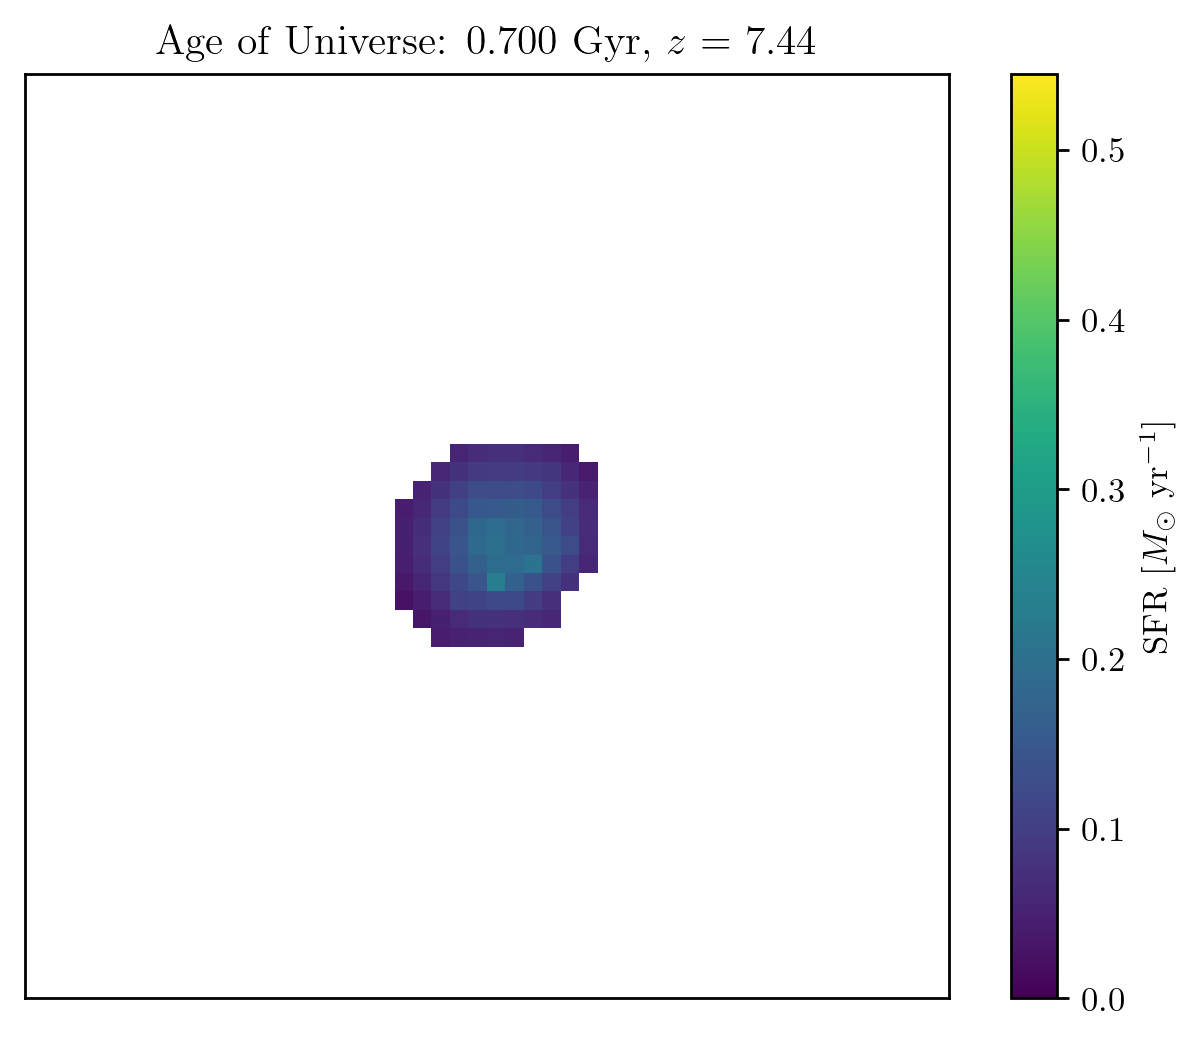

In [29]:
# MOVIE
from matplotlib.animation import FuncAnimation


# Set up the figure and image
x = sfr_x_axis(ages[0, :], z)
age_steps = x[x>0].shape[0]
steps_per_frame = 5
timesteps = int(age_steps / steps_per_frame)
fig, ax = plt.subplots()
data = np.zeros((Ncut, Ncut))
data[pix_mask] = sfh[:, 1, -1]
data[~pix_mask] = np.nan
im = ax.imshow(data, cmap='viridis', animated=True, vmin=0, vmax=np.max(sfh), origin='lower')
plt.colorbar(im, ax=ax, label='SFR [$M_{\\odot}$ yr$^{-1}$]')

# Update function for animation
def update(frame):
    data = np.zeros((Ncut, Ncut))
    data[pix_mask] = sfh[:, 1, x>0][:, -(5*frame)]
    data[~pix_mask] = np.nan
    im.set_array(data)
    xi = x[x>0][-(5*frame)]
    ax.set_title(f'Age of Universe: {xi:.3f} Gyr, $z$ = {redshift_from_age(xi):.2f}')
    ax.set_xticks([])
    ax.set_yticks([])
    print(f'frame {frame+1}/{timesteps} complete')
    return [im]

# Create animation
ani = FuncAnimation(fig, update, frames=timesteps, interval=100, blit=True)

# Save animation
ani.save(f'objid_{objid}_conv_pixSFH_5step.mp4', writer='ffmpeg', dpi=80)

# MOVIE, BUT LOG SCALE
# Set up the figure and image
x = sfr_x_axis(ages[0, :], z)
age_steps = x[x>0].shape[0]
steps_per_frame = 5
timesteps = int(age_steps / steps_per_frame)
fig, ax = plt.subplots()
data = np.zeros((Ncut, Ncut))
data[pix_mask] = np.log10(sfh[:, 1, -1])
data[~pix_mask] = np.nan
im = ax.imshow(data, cmap='viridis', animated=True, vmin=-10, vmax=np.max(np.log10(sfh)), origin='lower')
plt.colorbar(im, ax=ax, label='$\\log$(SFR / $M_{\\odot}$ yr$^{-1}$)')

# Update function for animation
def update(frame):
    data = np.zeros((Ncut, Ncut))
    data[pix_mask] = sfh[:, 1, x>0][:, -(5*frame)]
    data[~pix_mask] = np.nan
    im.set_array(data)
    xi = x[x>0][-(5*frame)]
    ax.set_title(f'Age of Universe: {xi:.3f} Gyr, $z$ = {redshift_from_age(xi):.2f}')
    ax.set_xticks([])
    ax.set_yticks([])
    print(f'frame {frame+1}/{timesteps} complete')
    return [im]

# Create animation
ani = FuncAnimation(fig, update, frames=timesteps, interval=100, blit=True)

# Save animation
ani.save(f'objid_{objid}_conv_pixSFH_5step_LOG.mp4', writer='ffmpeg', dpi=80)

In [20]:
# Save pixel data to a single HDF file
with h5.File(f'hdf_test_{objid}.hdf5', 'w') as hdf:
    obj_grp = hdf.create_group(f'{objid}')
    obj_grp.create_dataset('SFHs', shape=(Npix, 3, 1654), data=sfh)
    obj_grp.create_dataset('sSFR', shape=(Npix, 3), data=ssfr)
    obj_grp.create_dataset('Stellar Mass', shape=(Npix, 3), data=st_mass)
    obj_grp.create_dataset('tMW', shape=(Npix, 3), data=tMW)
    obj_grp.create_dataset('logU', shape=(Npix, 3), data=logU)
    obj_grp.create_dataset('SFR10_SFR90', shape=(Npix, 3), data=burst)
    obj_grp.create_dataset('SFH Ages', shape=1654, data=ages[0, :])

    print(hdf[f'{objid}'].keys())

<KeysViewHDF5 ['SFH Ages', 'SFHs', 'SFR10_SFR90', 'Stellar Mass', 'logU', 'sSFR', 'tMW']>


In [21]:
ssfr.shape

(102, 3)

In [22]:
Npix

102

In [23]:
np.max(np.log10(sfh))

/tmp/ipykernel_2661255/1687416085.py:1: RuntimeWarning: divide by zero encountered in log10
  np.max(np.log10(sfh))


-0.2639102305523186